# MODELING

## Packages

In [ ]:
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
import io
import numpy as np
import random
import seaborn as sns

from sklearn.preprocessing import RobustScaler, OneHotEncoder, label_binarize
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, f1_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


## Import

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/ML_Project/train_data.csv')

train_data = train_data.drop(columns=['propertyCode'])

train_data['floor'] = train_data['floor'].astype('category')
train_data['propertyType'] = train_data['propertyType'].astype('category')
train_data['district'] = train_data['district'].astype('category')
train_data['status'] = train_data['status'].astype('category')
train_data['Price_Category'] = train_data['Price_Category'].astype('category')

In [ ]:
test_data = pd.read_csv('/content/drive/MyDrive/ML_Project/test_data.csv')

test_data = test_data.drop(columns=['propertyCode'])

test_data['floor'] = test_data['floor'].astype('category')
test_data['propertyType'] = test_data['propertyType'].astype('category')
test_data['district'] = test_data['district'].astype('category')
test_data['status'] = test_data['status'].astype('category')
test_data['Price_Category'] = test_data['Price_Category'].astype('category')

## Scale numerical variables and Encode Categorical

In [ ]:
numerical_columns = ['size', 'rooms', 'bathrooms', 'latitude', 'longitude', 'Less_than_Primary', 'Lower_Secondary',
                     'Primary', 'Tertiary', 'Upper_Secondary_or_Post_Secondary',
                     'Distribucio_P80_20', 'American_population', 'Asian_population', 'African_population',
                     'European_population', 'Oceanian_population', 'Population_20_44', 'Population_45_69', 'Population_less_than_19',
                     'Population_greater_than_70', 'price']

scaler = RobustScaler()
scaler.fit(train_data[numerical_columns])

# Transform both the training and testing data using the scaler
train_data_scaled = scaler.transform(train_data[numerical_columns])
test_data_scaled = scaler.transform(test_data[numerical_columns])

train_data_scaled = pd.DataFrame(train_data_scaled, columns=numerical_columns)
test_data_scaled = pd.DataFrame(test_data_scaled, columns=numerical_columns)

# Drop original numerical columns and concatenate with scaled columns
train_data = train_data.drop(columns=numerical_columns).reset_index(drop=True)
test_data = test_data.drop(columns=numerical_columns).reset_index(drop=True)

train_data = pd.concat([train_data, train_data_scaled], axis=1)
test_data = pd.concat([test_data, test_data_scaled], axis=1)

In [ ]:
floor_desired_order = ['sótano', 'bajo', 'chalet', 'entreplanta', 'entresuelo', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                 '10 to 13', '14 to 16', '17 to 25', 'penthouse']
floor_mapping = {floor: index for index, floor in enumerate(floor_desired_order)}

price_desired_order = ['Low', 'Medium', 'High', 'Very High']
price_mapping = {price: index for index, price in enumerate(price_desired_order)}

# Specify categorical columns
categorical_columns = ['floor', 'propertyType', 'district', 'status']
one_hot_encoded_columns = ['propertyType', 'district', 'status']

# Label Encoding for 'floor'
train_data['floor'] = train_data['floor'].map(floor_mapping).astype(int)
test_data['floor'] = test_data['floor'].map(floor_mapping).astype(int)

# Label Encoding for 'Price_Category'
train_data['Price_Category'] = train_data['Price_Category'].map(price_mapping)
test_data['Price_Category'] = test_data['Price_Category'].map(price_mapping)

# One-Hot Encoding for the remaining categorical columns
one_hot_encoder = OneHotEncoder(drop='first', sparse=False)
X_train_oh = pd.DataFrame(one_hot_encoder.fit_transform(train_data[one_hot_encoded_columns]))
X_train_oh.columns = one_hot_encoder.get_feature_names_out(one_hot_encoded_columns)

X_test_oh = pd.DataFrame(one_hot_encoder.transform(test_data[one_hot_encoded_columns]), columns=one_hot_encoder.get_feature_names_out(one_hot_encoded_columns))

# Drop original one-hot encoded columns and concatenate with encoded columns
train_data = train_data.drop(columns=one_hot_encoded_columns).reset_index(drop=True)
test_data = test_data.drop(columns=one_hot_encoded_columns).reset_index(drop=True)

train_data = pd.concat([train_data, X_train_oh], axis=1)
test_data = pd.concat([test_data, X_test_oh], axis=1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Feature Selection / Extraction

#### Correlation Matrix

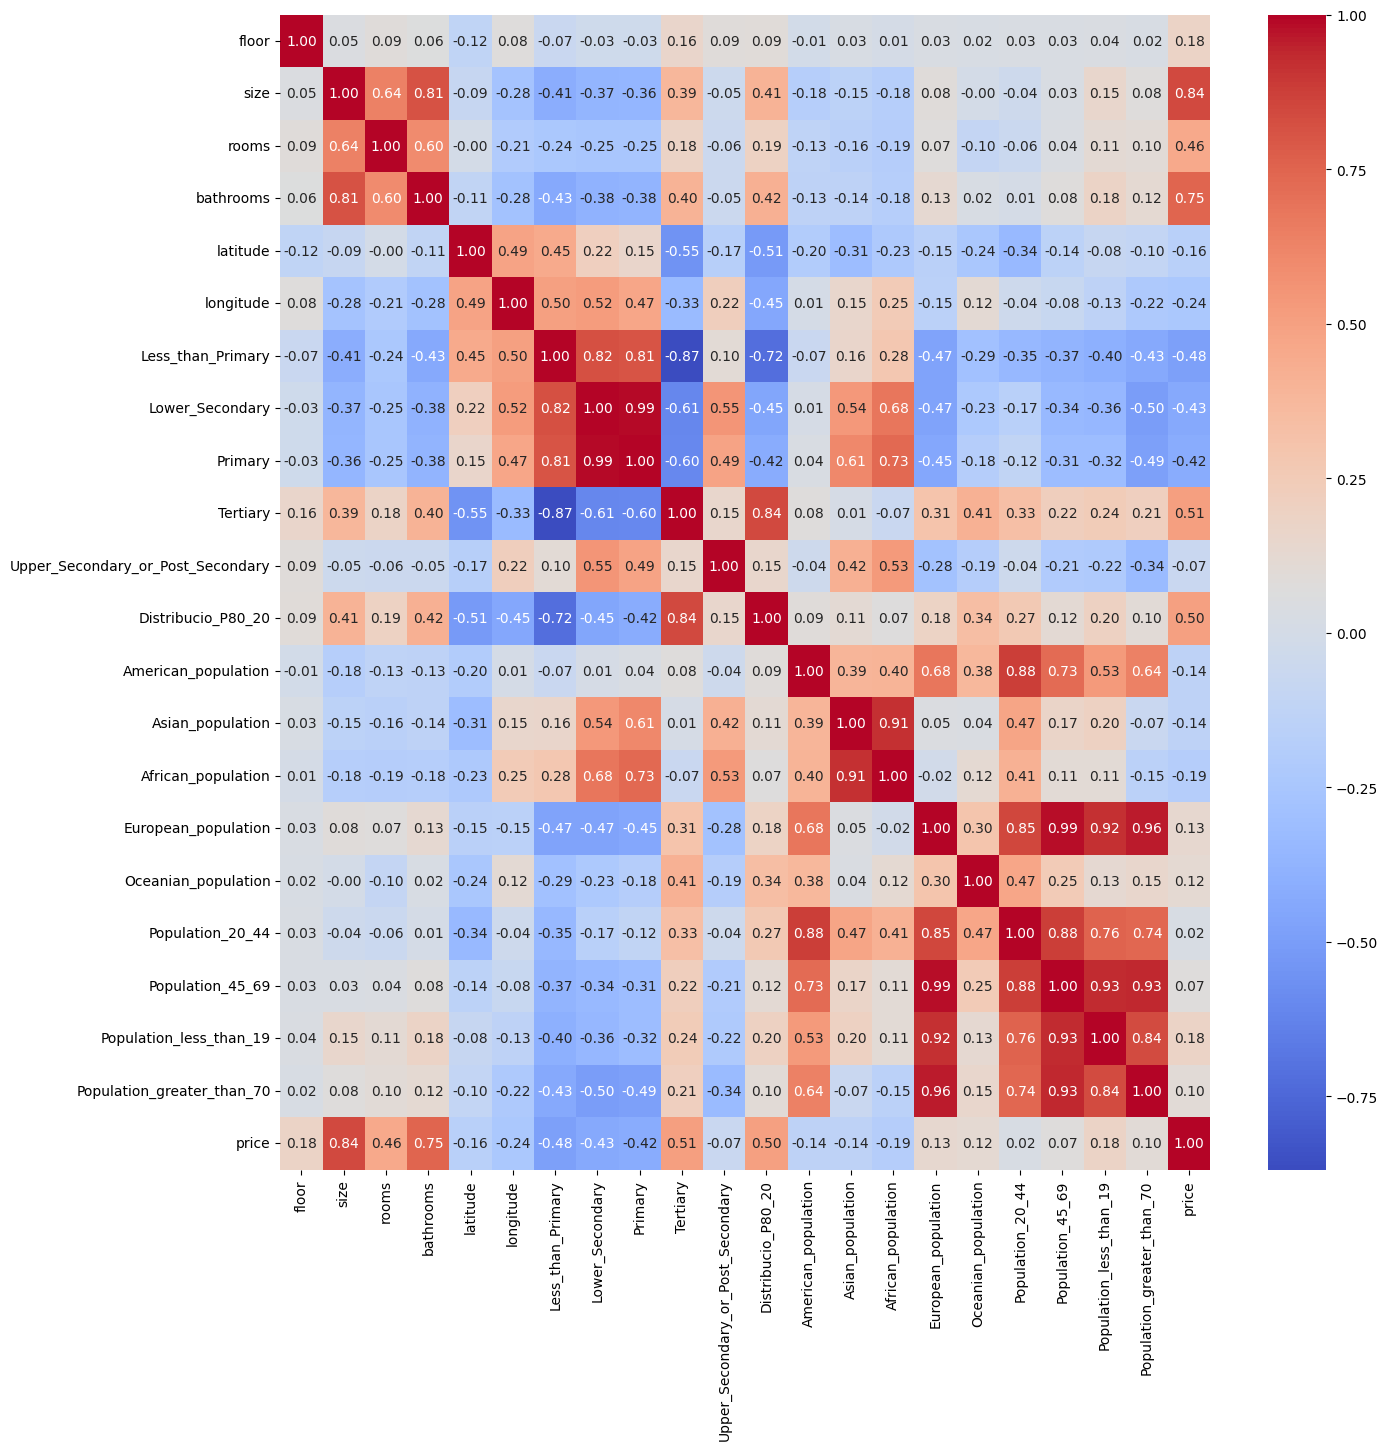

In [ ]:
numerical_columns = ['floor','size', 'rooms', 'bathrooms', 'latitude', 'longitude', 'Less_than_Primary', 'Lower_Secondary',
                     'Primary', 'Tertiary', 'Upper_Secondary_or_Post_Secondary',
                     'Distribucio_P80_20', 'American_population', 'Asian_population', 'African_population',
                     'European_population', 'Oceanian_population', 'Population_20_44', 'Population_45_69', 'Population_less_than_19',
                     'Population_greater_than_70', 'price']
train_data_scaled_num = train_data[numerical_columns]
# Correlation between numericals
plt.figure(figsize=(15, 15))
sns.heatmap(train_data_scaled_num.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

Looking at the correlation matrix between numerical variables, we decided to remove the following values:

- All the Age range variables, as they are highly correlated with each other and with the `European_Population` variable.
- The `African_Population` variable, as it is highly correlated with the `Asian_Population` and the `Primary` education variable.
- Finally, two education variables (`Less_than_Primary`, `Lower_Secondary`), as they are highly correlated with the other three education variables.



In [ ]:
train_data = train_data.drop(columns=['African_population', 'Less_than_Primary','Lower_Secondary', 'Population_20_44', 'Population_45_69', 'Population_less_than_19', 'Population_greater_than_70'])
test_data = test_data.drop(columns=['African_population', 'Less_than_Primary','Lower_Secondary', 'Population_20_44', 'Population_45_69', 'Population_less_than_19', 'Population_greater_than_70'])
test_data.to_csv('/content/drive/MyDrive/ML_Project/test_data_encoded.csv', index=False)

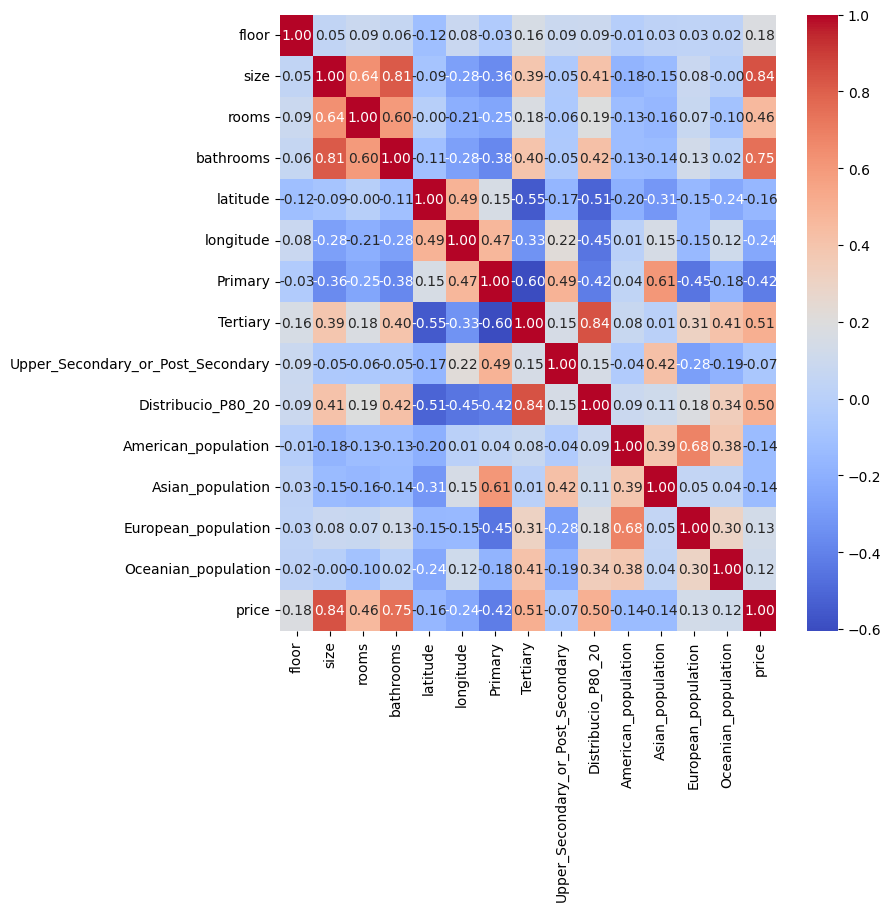

In [ ]:
numerical_columns = ['floor', 'size', 'rooms', 'bathrooms', 'latitude', 'longitude',
                     'Primary', 'Tertiary', 'Upper_Secondary_or_Post_Secondary',
                     'Distribucio_P80_20', 'American_population', 'Asian_population',
                     'European_population', 'Oceanian_population', 'price']

train_data_scaled_num = train_data[numerical_columns]
plt.figure(figsize=(8, 8))
sns.heatmap(train_data_scaled_num.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

### PCA

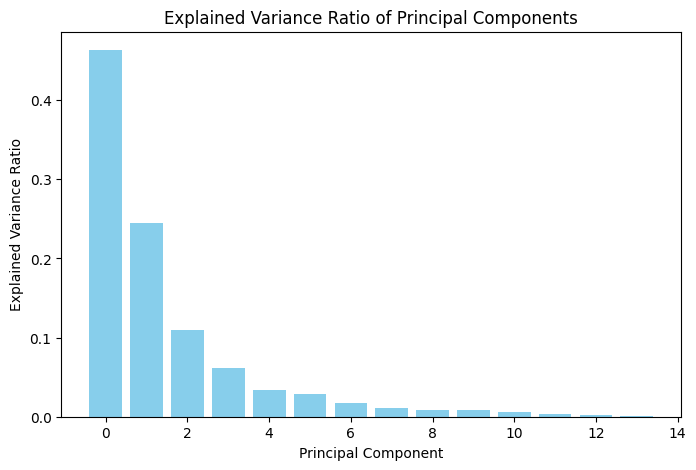

In [ ]:
#As we want to use PCs for creating the model we will drop the 'price' variable
train_data_pca = train_data_scaled_num.drop(columns=['price'])

pca = PCA()
pca.fit(train_data_pca)

# Plot explained variance ratio
plt.figure(figsize=(8, 5))
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_, color='skyblue')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio of Principal Components')
plt.show()

#### Scree Plot:

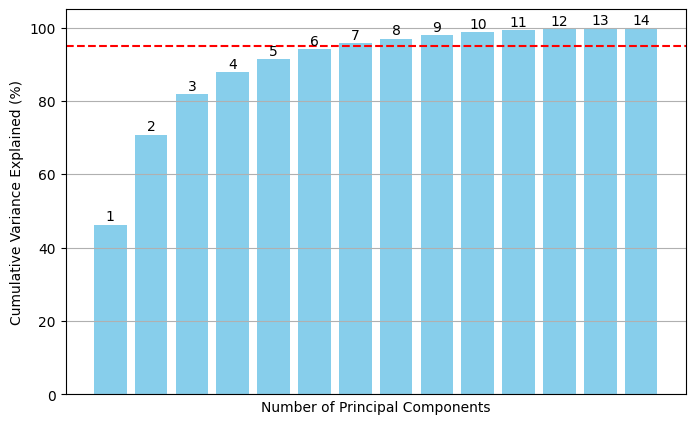

In [ ]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_ * 100)

plt.figure(figsize=(8, 5))
plt.bar(range(1, len(cumulative_variance) + 1), cumulative_variance, color='skyblue')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained (%)')
# plt.title('Scree Plot: Cumulative Variance Explained by Principal Components')
plt.grid(axis='y')
plt.xticks([])
plt.axhline(y=95, color='r', linestyle='--')
for i, var in enumerate(cumulative_variance):
    plt.text(i + 1, var + 1, str(i + 1), ha='center')
# plt.savefig('/content/drive/MyDrive/ML_Project/scree_plot.png')
plt.show()

In [ ]:
# Create alternative dataset with first 7 PCs
num_pc = 7
train_data_pca = pca.transform(train_data_pca)[:, :num_pc]
train_data_pca = pd.DataFrame(train_data_pca, columns=[f'PC{i+1}' for i in range(num_pc)])

test_data_pca = test_data[numerical_columns].drop(columns=['price'])
test_data_pca = pca.transform(test_data_pca)[:, :num_pc]
test_data_pca = pd.DataFrame(test_data_pca, columns=[f'PC{i+1}' for i in range(num_pc)])

#### Factorial Maps

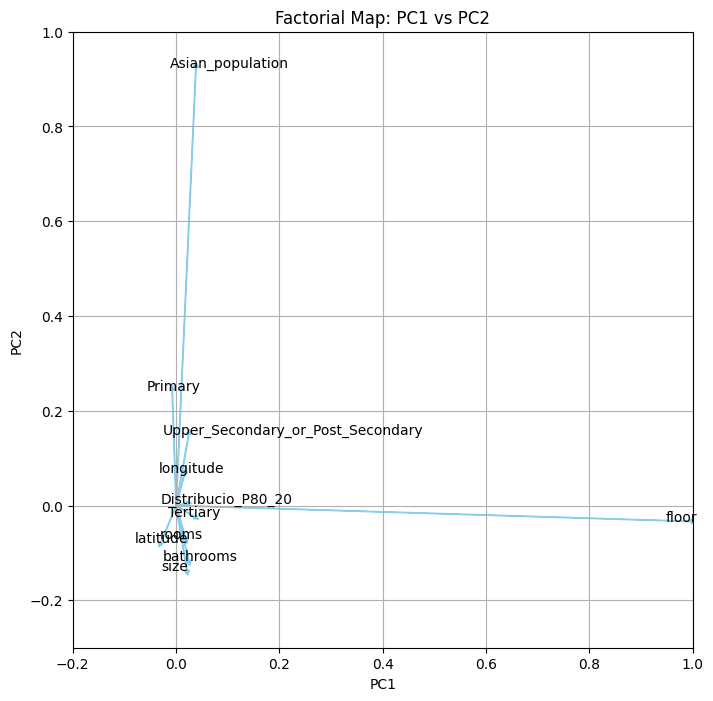

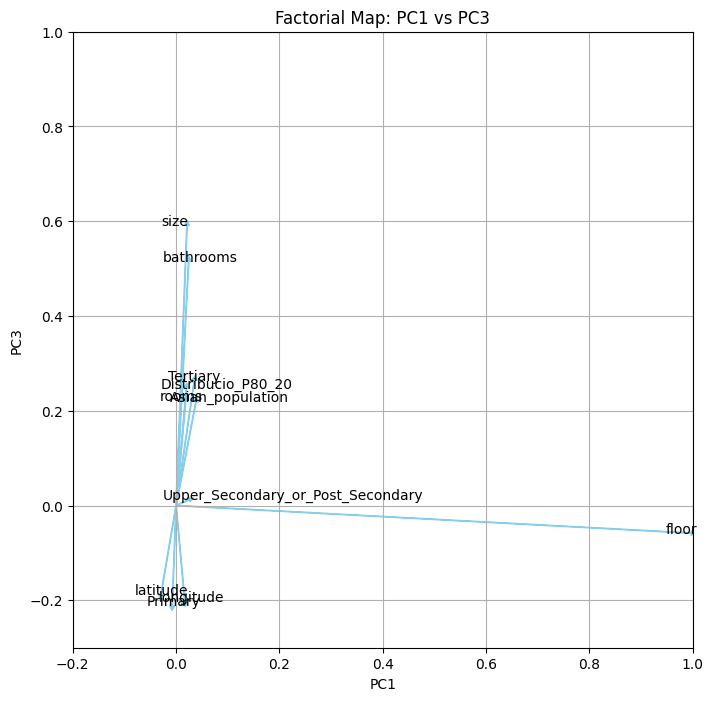

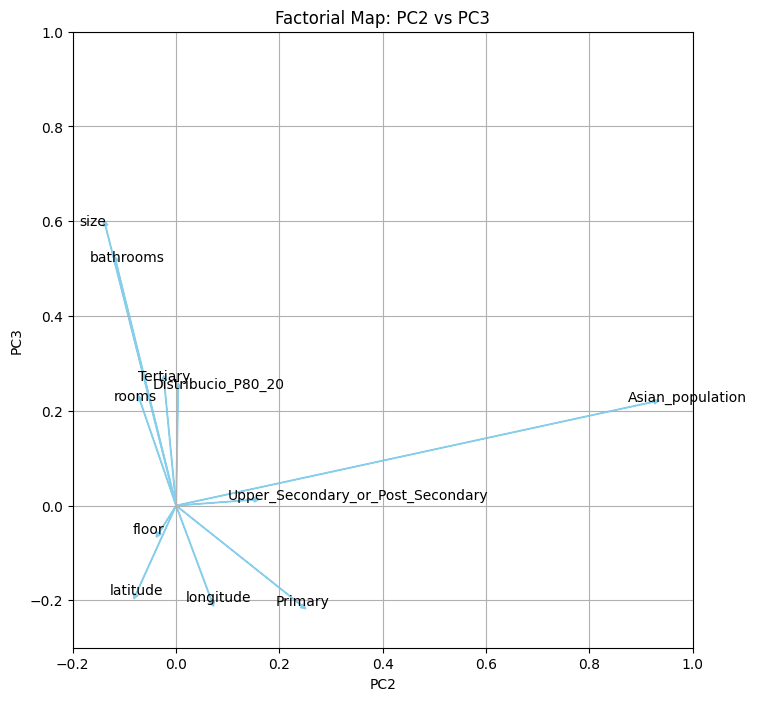

In [ ]:
# Plot factorial map with variable arrows for a given PC
def plot_factorial_map_with_arrows(pc1_index, pc2_index):
    plt.figure(figsize=(8, 8))

    for i, var in enumerate(train_data_scaled_num.drop(columns=['price']).columns):
      if (not 'population' in var) or (var == 'Asian_population'):
        plt.arrow(0, 0, pca.components_[pc1_index, i], pca.components_[pc2_index, i],
                  head_width=0.01, head_length=0.01, color='skyblue')
        plt.text(pca.components_[pc1_index, i] - 0.05, pca.components_[pc2_index, i], var, fontsize=10, color='black', ha='left')

    plt.xlim(-0.2, 1)
    plt.ylim(-0.3, 1)

    plt.xlabel(f'PC{pc1_index + 1}')
    plt.ylabel(f'PC{pc2_index + 1}')
    plt.title(f'Factorial Map: PC{pc1_index + 1} vs PC{pc2_index + 1}')
    plt.grid(True)
    # plt.savefig('/content/drive/MyDrive/ML_Project/plots/fm_pc1_pc2.png')
    plt.show()

plot_factorial_map_with_arrows(0, 1)  # PC1 vs PC2
plot_factorial_map_with_arrows(0, 2)  # PC1 vs PC3
plot_factorial_map_with_arrows(1, 2)  # PC2 vs PC3

In [ ]:
# Drop original numerical columns and concatenate with PCs columns
train_data_cat = train_data.drop(columns=numerical_columns).reset_index(drop=True)
test_data_cat = test_data.drop(columns=numerical_columns).reset_index(drop=True)

train_data_pca = pd.concat([train_data_pca, train_data_cat], axis=1)
test_data_pca = pd.concat([test_data_pca, test_data_cat], axis=1)

## Prepare X and y datasets

### Normal Dataset

In [ ]:
# Split the data
X_train = train_data.drop(columns=['Price_Category', 'price'])
y_train = train_data['Price_Category']

X_test = test_data.drop(columns=['Price_Category', 'price'])
y_test = test_data['Price_Category']

### PCA Dataset

In [ ]:
# Split the data
X_train_pca = train_data_pca.drop(columns=['Price_Category'])
y_train_pca = train_data_pca['Price_Category']

X_test_pca = test_data_pca.drop(columns=['Price_Category'])
y_test_pca = test_data_pca['Price_Category']

## Best Features Choice

We will monitor the performance of our model as we include more features and select the number of features that maximizes model performance through cross-validation. We will perform this analysis with 2 different datasets (with and without Principal Components).

### With Main dataframe

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train, y_train)

# Rank features by importance
feature_importances = rf_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Iteratively add features and evaluate performance using OOB error
features = feature_importance_df['Feature'].tolist()
scores = []
best_num_features = 0
best_score = 0
for num_features in range(1, len(features) + 1):
    selected_features = features[:num_features]
    X_train_subset = X_train[selected_features]

    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_samples = 0.7, oob_score=True)
    rf_classifier.fit(X_train_subset, y_train)

    # Obtain OOB predictions
    oob_pred = np.argmax(rf_classifier.oob_decision_function_, axis=1)

    f1 = f1_score(y_train, oob_pred, average='weighted')
    scores.append(f1)
    if f1 > best_score + 0.005:
        best_score = f1
        best_num_features = num_features

print(f'Best number of features: {best_num_features}')
print(f'Best OOB accuracy: {best_score}')

# Best subset of features
best_features = features[:best_num_features]
X_train_best = X_train[best_features]

X_test_best = X_test[best_features]

Best number of features: 8
Best OOB accuracy: 0.9059863410034903


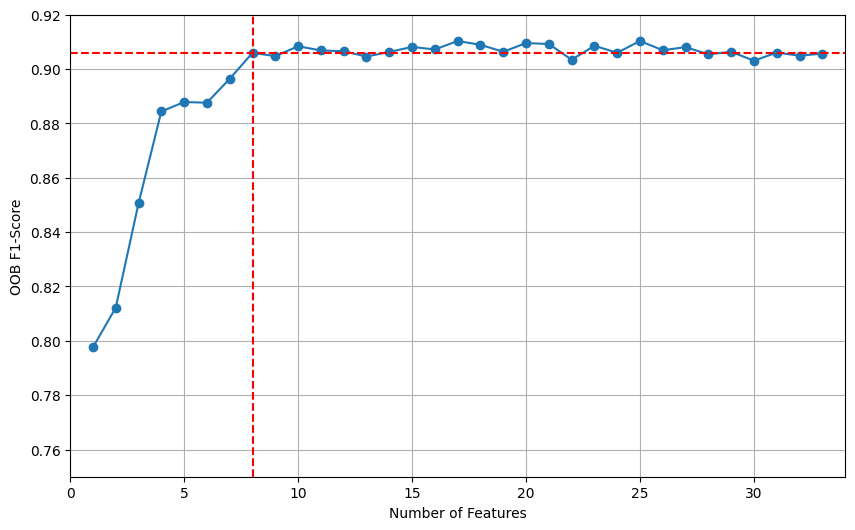

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(features) + 1), scores, marker='o')
plt.axhline(y=best_score, color='r', linestyle='--', label=f'Best OOB F1-Score: {best_score:.4f}')
plt.axvline(x=best_num_features, color='r', linestyle='--')
# plt.title('OOB F1-Score vs. Number of Features')
plt.xlim(0, 34)
plt.ylim(0.75, 0.92)
plt.xlabel('Number of Features')
plt.ylabel('OOB F1-Score')
plt.grid(True)
plt.tight_layout
#plt.savefig('/content/drive/MyDrive/ML_Project/oob_main.png')
plt.show()

### With PCA Dataframe

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_pca, y_train_pca)

# Rank features by importance
feature_importances = rf_classifier.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X_train_pca.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Iteratively add features and evaluate performance using OOB error
features_pca = feature_importance_df['Feature'].tolist()
scores = []
best_num_features = 0
best_score = 0
for num_features in range(1, len(features_pca) + 1):
    selected_features = features_pca[:num_features]
    X_train_subset = X_train_pca[selected_features]

    rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, max_samples = 0.7, oob_score=True)
    rf_classifier.fit(X_train_subset, y_train_pca)

    # Obtain OOB predictions
    oob_pred = np.argmax(rf_classifier.oob_decision_function_, axis=1)

    f1 = f1_score(y_train, oob_pred, average='weighted')
    scores.append(f1)

    if f1 > best_score + 0.005:
        best_score = f1
        best_num_features = num_features

print(f'Best number of features: {best_num_features}')
print(f'Best OOB accuracy: {best_score}')

# Best subset of features
best_features = features_pca[:best_num_features]
X_train_pca_best = X_train_pca[best_features]

X_test_pca_best = X_test_pca[best_features]

Best number of features: 8
Best OOB accuracy: 0.8836909354455764


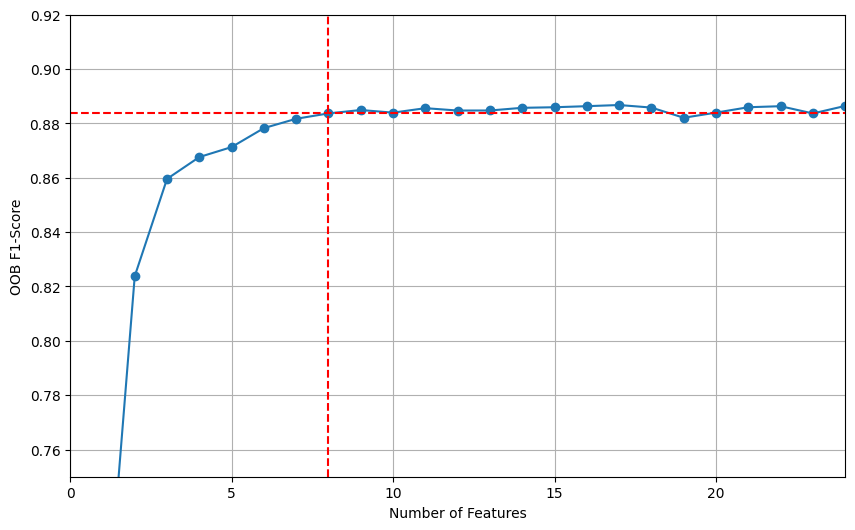

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(features_pca) + 1), scores, marker='o')
plt.axhline(y=best_score, color='r', linestyle='--', label=f'Best OOB F1-Score: {best_score:.4f}')
plt.axvline(x=best_num_features, color='r', linestyle='--')
plt.xlim(0, 24)
plt.ylim(0.75, 0.92)
# plt.title('OOB F1-Score vs. Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('OOB F1-Score')
plt.grid(True)
plt.tight_layout
#plt.savefig('/content/drive/MyDrive/ML_Project/oob_pca.png')
plt.show()

In [ ]:
best_features

['PC3', 'PC2', 'PC4', 'PC5', 'PC6', 'PC7', 'PC1', 'hasParkingSpace']

## Modeling

### Logistic Regression

#### Hyperparameters tunning

In [ ]:
logistic_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=200)

# Define the hyperparameters and the grid search
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'penalty': ['l2']  # L2 regularization is supported for multinomial logistic regression
}

# Grid Search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=logistic_model, param_grid=param_grid, cv=5, verbose=1, n_jobs=-1, refit='f1_weighted')

# Fit the model
grid_search.fit(X_train_best, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=200,
                                          multi_class='multinomial'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l2']},
             refit='f1_weighted', verbose=1)

#### Validation

In [ ]:
best_logistic_model = grid_search.best_estimator_

# Predict the test set results
y_pred = best_logistic_model.predict(X_test_best)

reverse_price_mapping = {index: price for price, index in price_mapping.items()}
y_pred_dec = pd.Series(y_pred).map(reverse_price_mapping)
y_test_dec = pd.Series(y_test).map(reverse_price_mapping)

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test_dec, y_pred_dec))

Classification Report:
              precision    recall  f1-score   support

        High       0.67      0.57      0.62       176
         Low       0.92      0.95      0.94      1114
      Medium       0.73      0.74      0.73       461
   Very High       0.87      0.41      0.55        32

    accuracy                           0.85      1783
   macro avg       0.80      0.67      0.71      1783
weighted avg       0.84      0.85      0.84      1783



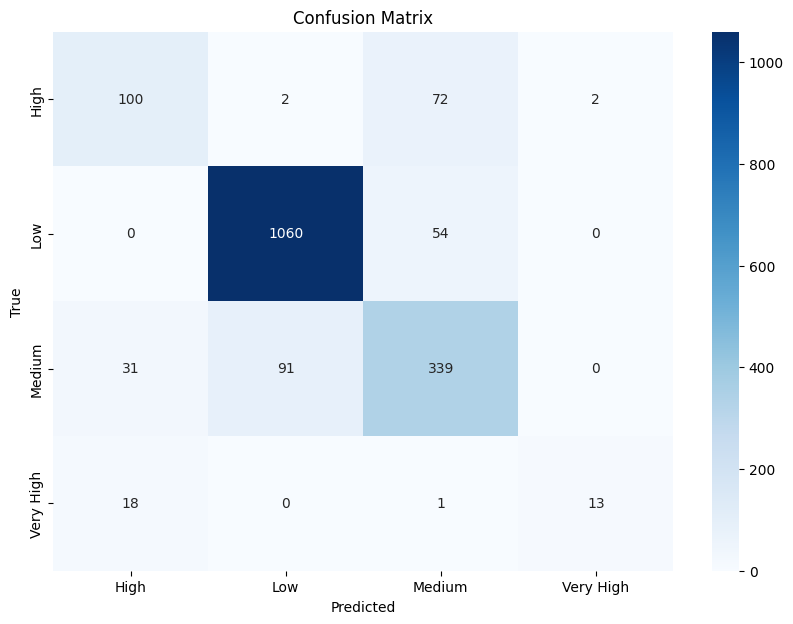

In [ ]:
classes = sorted(y_test_dec.unique())
# Generate the confusion matrix
cm = confusion_matrix(y_test_dec, y_pred_dec)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


### Random Forest Classifier

#### Hyperparameters tunning

In [44]:
# Define a function to perform the grid search for hyperparameter tuning
def tune_random_forest(X_train_best, y_train, n_estimators_list, max_samples_list, max_features_list):
    best_f1_score = 0
    best_params = {}
    np.random.seed(42)
    for n_estimators in n_estimators_list:
        for max_samples in max_samples_list:
            for max_features in max_features_list:
                rf_classifier = RandomForestClassifier(
                    n_estimators=n_estimators,
                    max_samples=max_samples,
                    max_features=max_features,
                    random_state=42,
                    oob_score=True
                )

                # Fit the model
                rf_classifier.fit(X_train_best, y_train)
                oob_error = 1 - rf_classifier.oob_score_
                 # Obtain OOB predictions
                oob_pred = np.argmax(rf_classifier.oob_decision_function_, axis=1)

                f1 = f1_score(y_train, oob_pred, average='weighted')
                # Update the best parameters based on F1-weighted score
                if f1 > best_f1_score + 0.005:
                    best_f1_score = f1
                    best_params = {
                        'n_estimators': n_estimators,
                        'max_samples': max_samples,
                        'max_features': max_features,
                        'best_score': best_f1_score
                    }

    return best_params, best_f1_score

# Hyperparameters ranges to search
n_estimators_list = [100, 150, 180]
max_samples_list = [0.5, 0.7, 0.9]
max_features_list = ['sqrt', 'log2']

# Tune hyperparameters
best_params, best_f1_score = tune_random_forest(X_train_best, y_train, n_estimators_list, max_samples_list, max_features_list)

print(f"Best parameters: {best_params}")
print(f"Best F1-weighted score: {best_f1_score}")

Best parameters: {'n_estimators': 100, 'max_samples': 0.7, 'max_features': 'log2', 'best_score': 0.9080861506458743}
Best F1-weighted score: 0.9080861506458743


#### Validation

In [45]:
# Train the final model with the best parameters
rf_classifier = RandomForestClassifier(
    n_estimators=best_params['n_estimators'],
    max_samples=best_params['max_samples'],
    max_features=best_params['max_features'],
    random_state=42
)

rf_classifier.fit(X_train_best, y_train)

y_pred = rf_classifier.predict(X_test_best)

y_pred_prob = rf_classifier.predict_proba(X_test_best)

reverse_price_mapping = {index: price for price, index in price_mapping.items()}
y_pred_dec = pd.Series(y_pred).map(reverse_price_mapping)
y_test_dec = pd.Series(y_test).map(reverse_price_mapping)

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test_dec, y_pred_dec))

Classification Report:
              precision    recall  f1-score   support

        High       0.81      0.82      0.82       176
         Low       0.96      0.96      0.96      1114
      Medium       0.85      0.85      0.85       461
   Very High       0.90      0.59      0.72        32

    accuracy                           0.91      1783
   macro avg       0.88      0.81      0.84      1783
weighted avg       0.91      0.91      0.91      1783



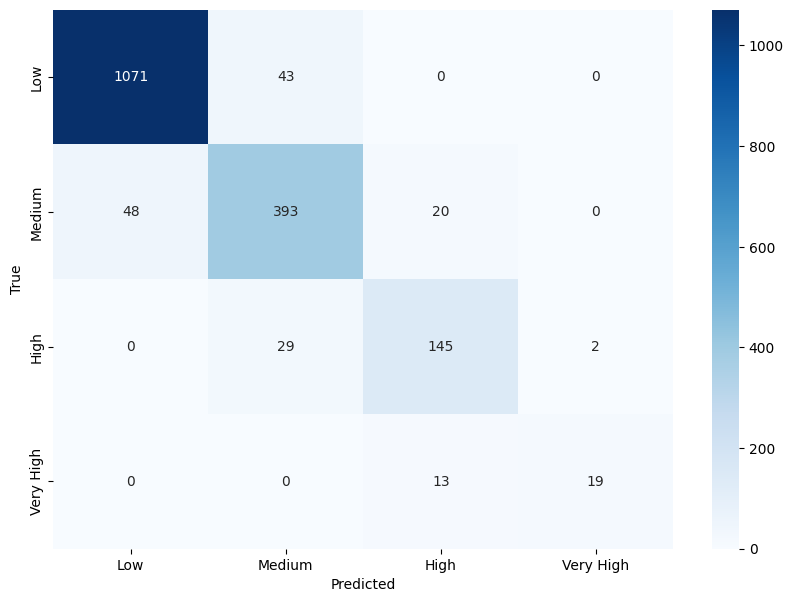

In [46]:
classes = y_test_dec.unique()

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_dec, y_pred_dec, labels=classes)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
#plt.savefig('/content/drive/MyDrive/ML_Project/conf_matrix.png')
plt.show()

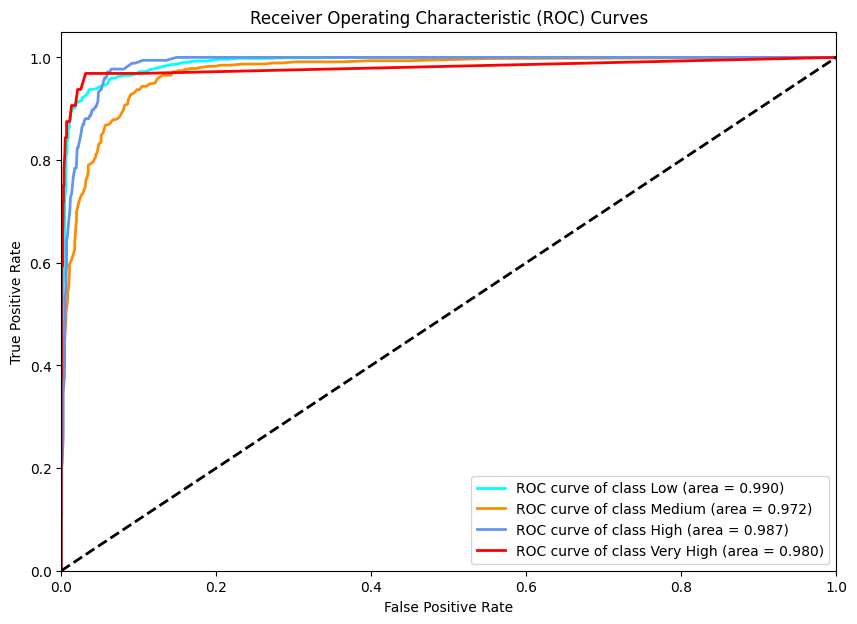

In [47]:
# Binarize the output
y_test_bin = label_binarize(y_test_dec, classes=classes)
n_classes = y_test_bin.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 7))
colors = ['aqua', 'darkorange', 'cornflowerblue', 'red']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.3f})'.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
#plt.savefig('/content/drive/MyDrive/ML_Project/roc_curves.png')
plt.show()


### Support Vector Machines

#### Hyperparameters tunning

In [ ]:
# Add more features
best_features = features[:25]
X_train_best = X_train[best_features]

X_test_best = X_test[best_features]

# Define the SVM classifier
svm_classifier = SVC()

# Define the hyperparameters grid for tuning
param_grid = {
    'C': [1, 100, 150],  # Regularization parameter
    'kernel': ['rbf'],  # Kernel type
    'gamma': ['scale', 'auto'],  # Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
}

# Perform grid search cross-validation to find the best hyperparameters
grid_search = GridSearchCV(svm_classifier, param_grid, cv=5, refit='f1_weighted')
grid_search.fit(X_train_best, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'C': 150, 'gamma': 'auto', 'kernel': 'rbf'}


#### Evaluation

In [ ]:
# Train the SVM classifier with the best hyperparameters
best_svm_classifier = SVC(**best_params)
best_svm_classifier.fit(X_train_best, y_train)

# Make predictions on the test set
y_pred = best_svm_classifier.predict(X_test_best)

reverse_price_mapping = {index: price for price, index in price_mapping.items()}
y_pred_dec = pd.Series(y_pred).map(reverse_price_mapping)
y_test_dec = pd.Series(y_test).map(reverse_price_mapping)

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test_dec, y_pred_dec))

Classification Report:
              precision    recall  f1-score   support

        High       0.82      0.79      0.80       176
         Low       0.95      0.96      0.96      1114
      Medium       0.85      0.84      0.84       461
   Very High       0.74      0.72      0.73        32

    accuracy                           0.91      1783
   macro avg       0.84      0.83      0.83      1783
weighted avg       0.91      0.91      0.91      1783



### KNN

#### Hyperparameter tunning

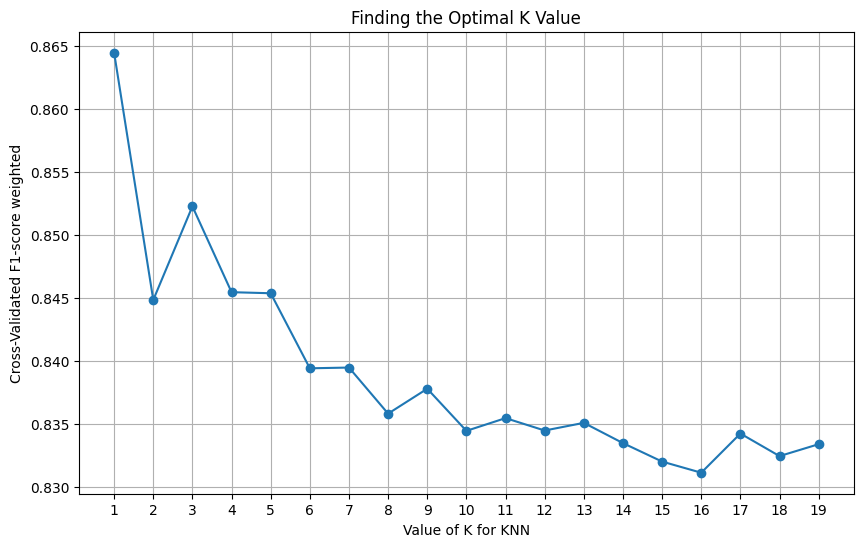

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

best_features = features[:8]
X_train_best = X_train[best_features]

X_test_best = X_test[best_features]
k_range = range(1, 20)
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train_best, y_train, cv=5, scoring='f1_weighted')
    k_scores.append(scores.mean())

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(k_range, k_scores, marker='o')
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated F1-score weighted')
plt.title('Finding the Optimal K Value')
plt.grid()
plt.xticks(k_range)
#plt.savefig('/content/drive/MyDrive/ML_Project/optimal_kvalue.png')
plt.show()

#### Evaluation

In [ ]:
optimal_k = k_range[np.argmax(k_scores)]
print(f'The optimal number of neighbors is {optimal_k}.')
knn_optimal = KNeighborsClassifier(n_neighbors=1)
knn_optimal.fit(X_train_best, y_train)
y_pred = knn_optimal.predict(X_test_best)

reverse_price_mapping = {index: price for price, index in price_mapping.items()}
y_pred_dec = pd.Series(y_pred).map(reverse_price_mapping)
y_test_dec = pd.Series(y_test).map(reverse_price_mapping)

# Detailed classification report
print("Classification Report:")
print(classification_report(y_test_dec, y_pred_dec))

The optimal number of neighbors is 1.
Classification Report:
              precision    recall  f1-score   support

        High       0.78      0.73      0.76       176
         Low       0.95      0.94      0.95      1114
      Medium       0.79      0.82      0.80       461
   Very High       0.74      0.81      0.78        32

    accuracy                           0.89      1783
   macro avg       0.82      0.83      0.82      1783
weighted avg       0.89      0.89      0.89      1783

